## Import nessesory libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import warnings
import io
import requests
from datetime import datetime
import os
warnings.filterwarnings('ignore')

In [2]:
import holidays

# Initialize French holiday calendar
fr_holidays = holidays.France(years=range(2006, 2011))

# Get all holiday dates in the period
holiday_dates = list(fr_holidays.keys())
print(f"French Holidays (2006–2010):\n{holiday_dates[:5]}...")  # Preview first 5

French Holidays (2006–2010):
[datetime.date(2006, 1, 1), datetime.date(2006, 5, 1), datetime.date(2006, 5, 8), datetime.date(2006, 7, 14), datetime.date(2006, 11, 11)]...


## Fetch data from URL....

In [22]:
file_id = "1c222AbSUMn9vKcepLZDnyCKUN2B8BQtP"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url, sep=',', low_memory=False)

In [6]:
# Display the first few rows of the dataset
print("===Dataset Overview===")
print("Shape: ",df.shape)
print("\nFirst 5 rows:")
df.head()

===Dataset Overview===
Shape:  (1441, 11)

First 5 rows:


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions
0,2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy"
1,2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy"
2,2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy
3,2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy
4,2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy


In [9]:
# Check data types and missing values
# Print dtype in one column and missing values in another
print("\n===Data Types and Missing Values===")
df_dtypes_missing = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum()
}).reset_index().rename(columns={'index': 'Column'})
print(df_dtypes_missing)


===Data Types and Missing Values===
                   Column Data Type  Missing Values
0                datetime    object               0
1     Global_active_power   float64              15
2   Global_reactive_power   float64              15
3                 Voltage   float64              15
4        Global_intensity   float64              15
5          Sub_metering_1   float64              15
6          Sub_metering_2   float64              15
7          Sub_metering_3   float64              15
8                    temp   float64               0
9                humidity   float64               0
10             conditions    object               0


In [10]:
# Basic statistics
print("\nBasic Statistics:")
df.describe()


Basic Statistics:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1441.000000,1441.000000
mean,0.747679,0.116410,242.672195,3.162973,0.532258,0.697055,3.308555,12.188494,72.586676
std,0.795084,0.100699,2.770333,3.292621,4.249666,3.454682,6.499891,6.437531,11.663047
min,0.080000,0.000000,229.400000,0.200000,0.000000,0.000000,0.000000,-4.720000,35.100000
25%,0.290000,0.048000,241.232500,1.200000,0.000000,0.000000,0.000000,7.560000,64.600000
50%,0.398000,0.100000,242.880000,1.800000,0.000000,0.000000,0.000000,12.440000,73.700000
75%,0.956500,0.186000,244.370000,4.000000,0.000000,1.000000,1.000000,17.500000,81.400000
max,5.806000,0.588000,251.710000,24.400000,40.000000,74.000000,20.000000,27.220000,97.100000


In [23]:
# Convert datetime to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

Time Range & Frequency Check:

Date Range: From 2006-12-17 to 2010-11-26

Frequency: Daily (1 day intervals)

The plot shows that the data is consistently recorded on a daily basis, with no significant missing chunks.

In [24]:
# Detecting and handling missing values
missing_dates = df[df.isnull().any(axis=1)]
if not missing_dates.empty:
    print("\nMissing Values Detected:")
    # filling missing values with forward and backward fill
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    # Check for missing values again
    print("\nMissing Values After Filling:")
    print(df[df.isnull().any(axis=1)])
else:
    print("\nNo Missing Values Detected")
    



Missing Values Detected:

Missing Values After Filling:
Empty DataFrame
Columns: [Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3, temp, humidity, conditions]
Index: []


In [25]:
# Before checking the correlation matrix we need to deal our categorical variables
df = pd.get_dummies(df, columns=['conditions'], drop_first=True)
#df=df.drop(columns=['date'], axis=1)

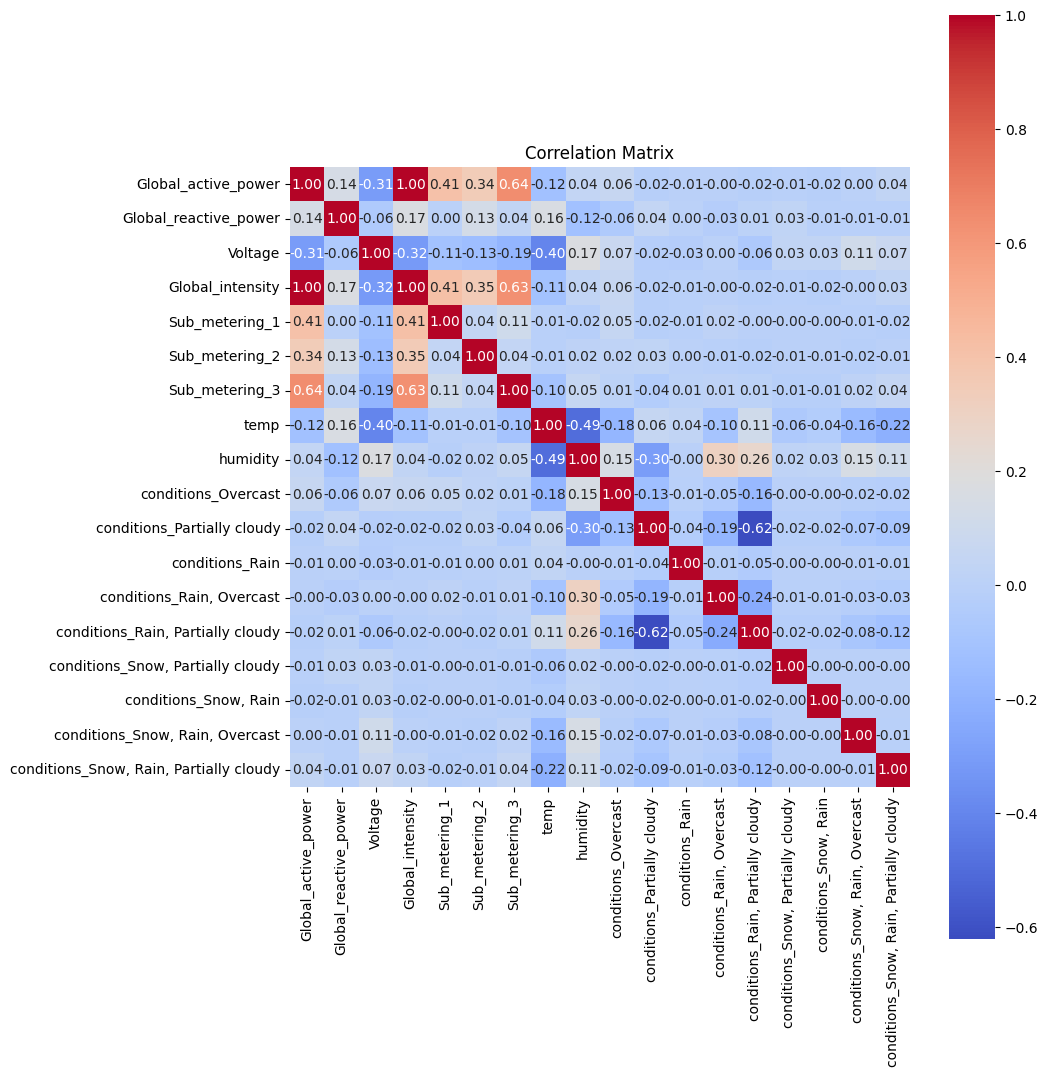

In [17]:
# Correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

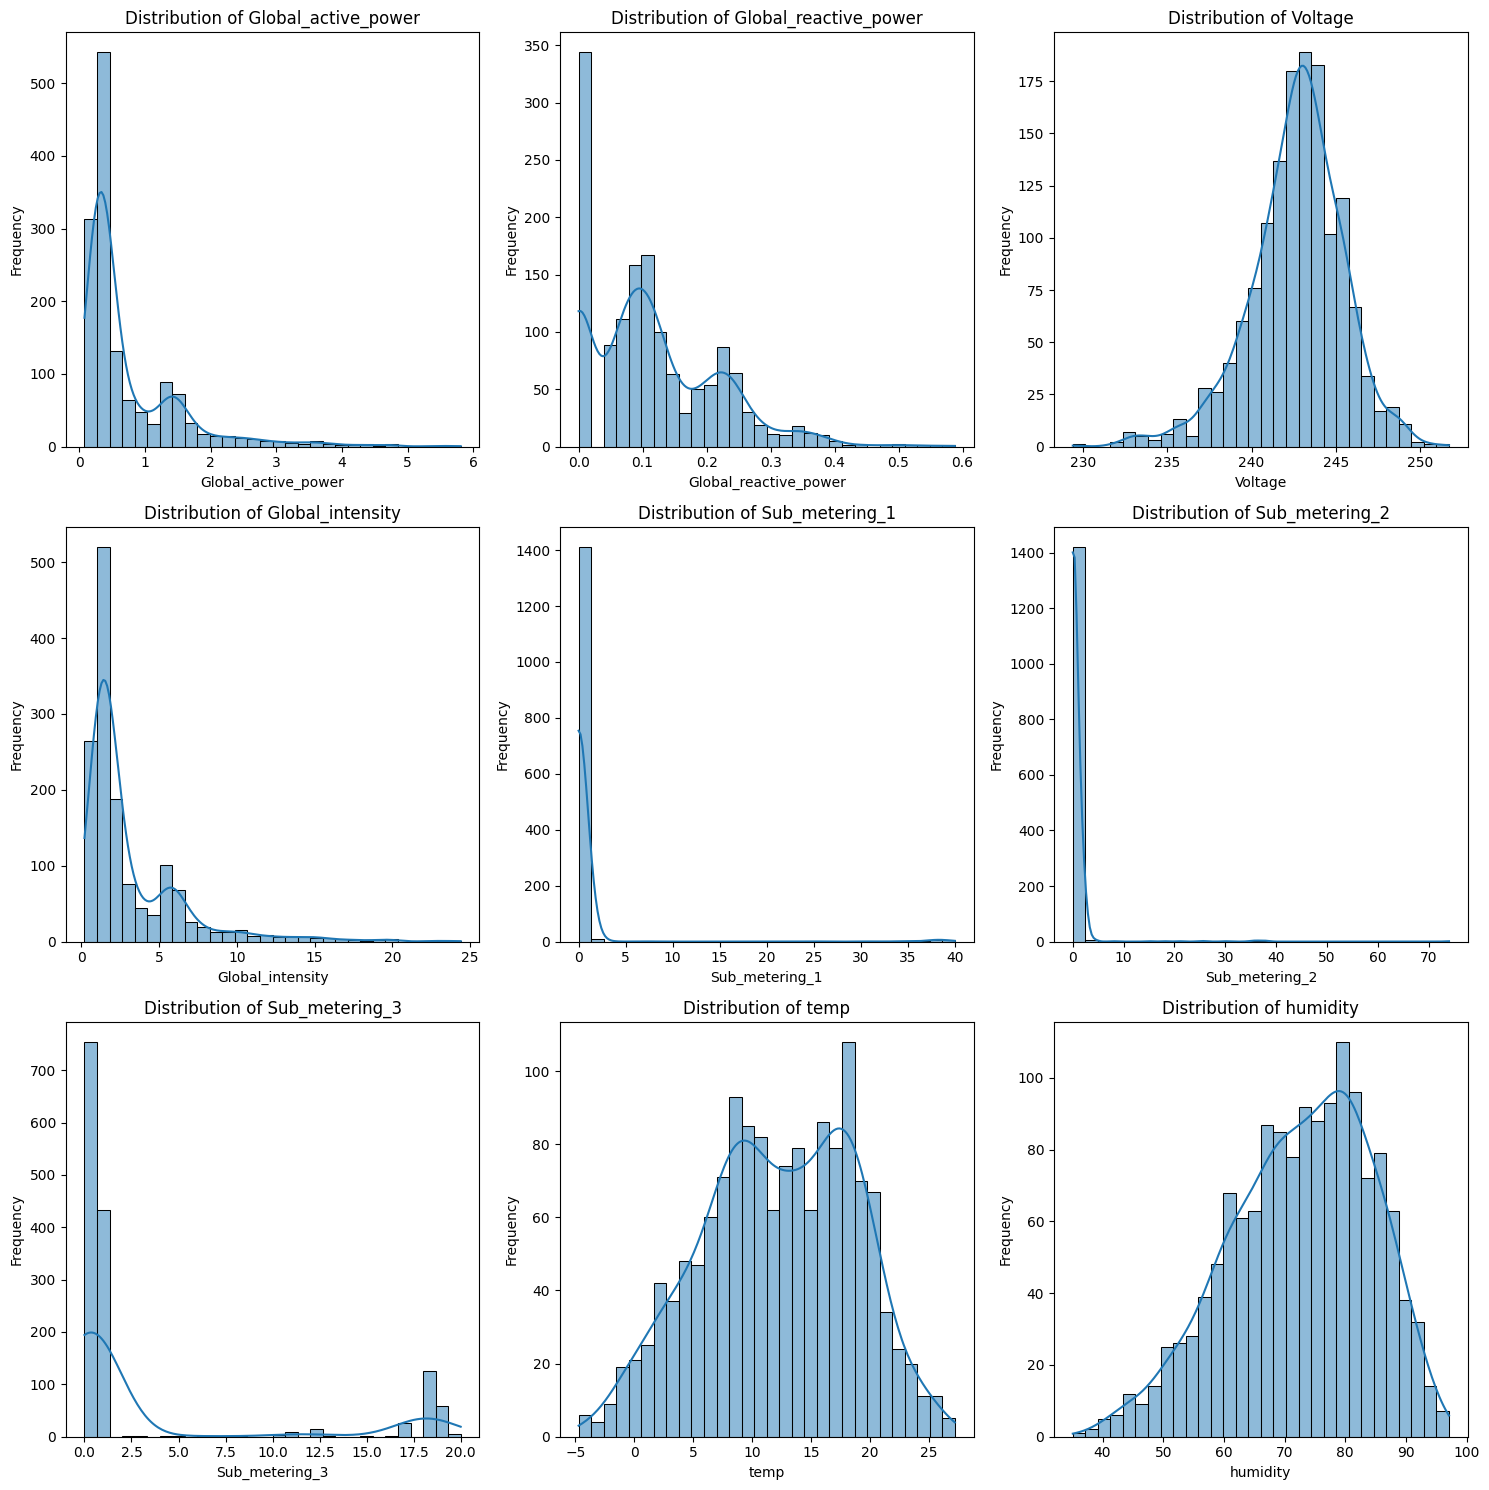

In [20]:
#Plot the distribution of the all variables(each row 3 distribution)
def plot_variable_distributions(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    num_vars = len(numeric_columns)
    num_cols = 3
    num_rows = (num_vars + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, column in enumerate(numeric_columns):
        sns.histplot(df[column], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_variable_distributions(df)

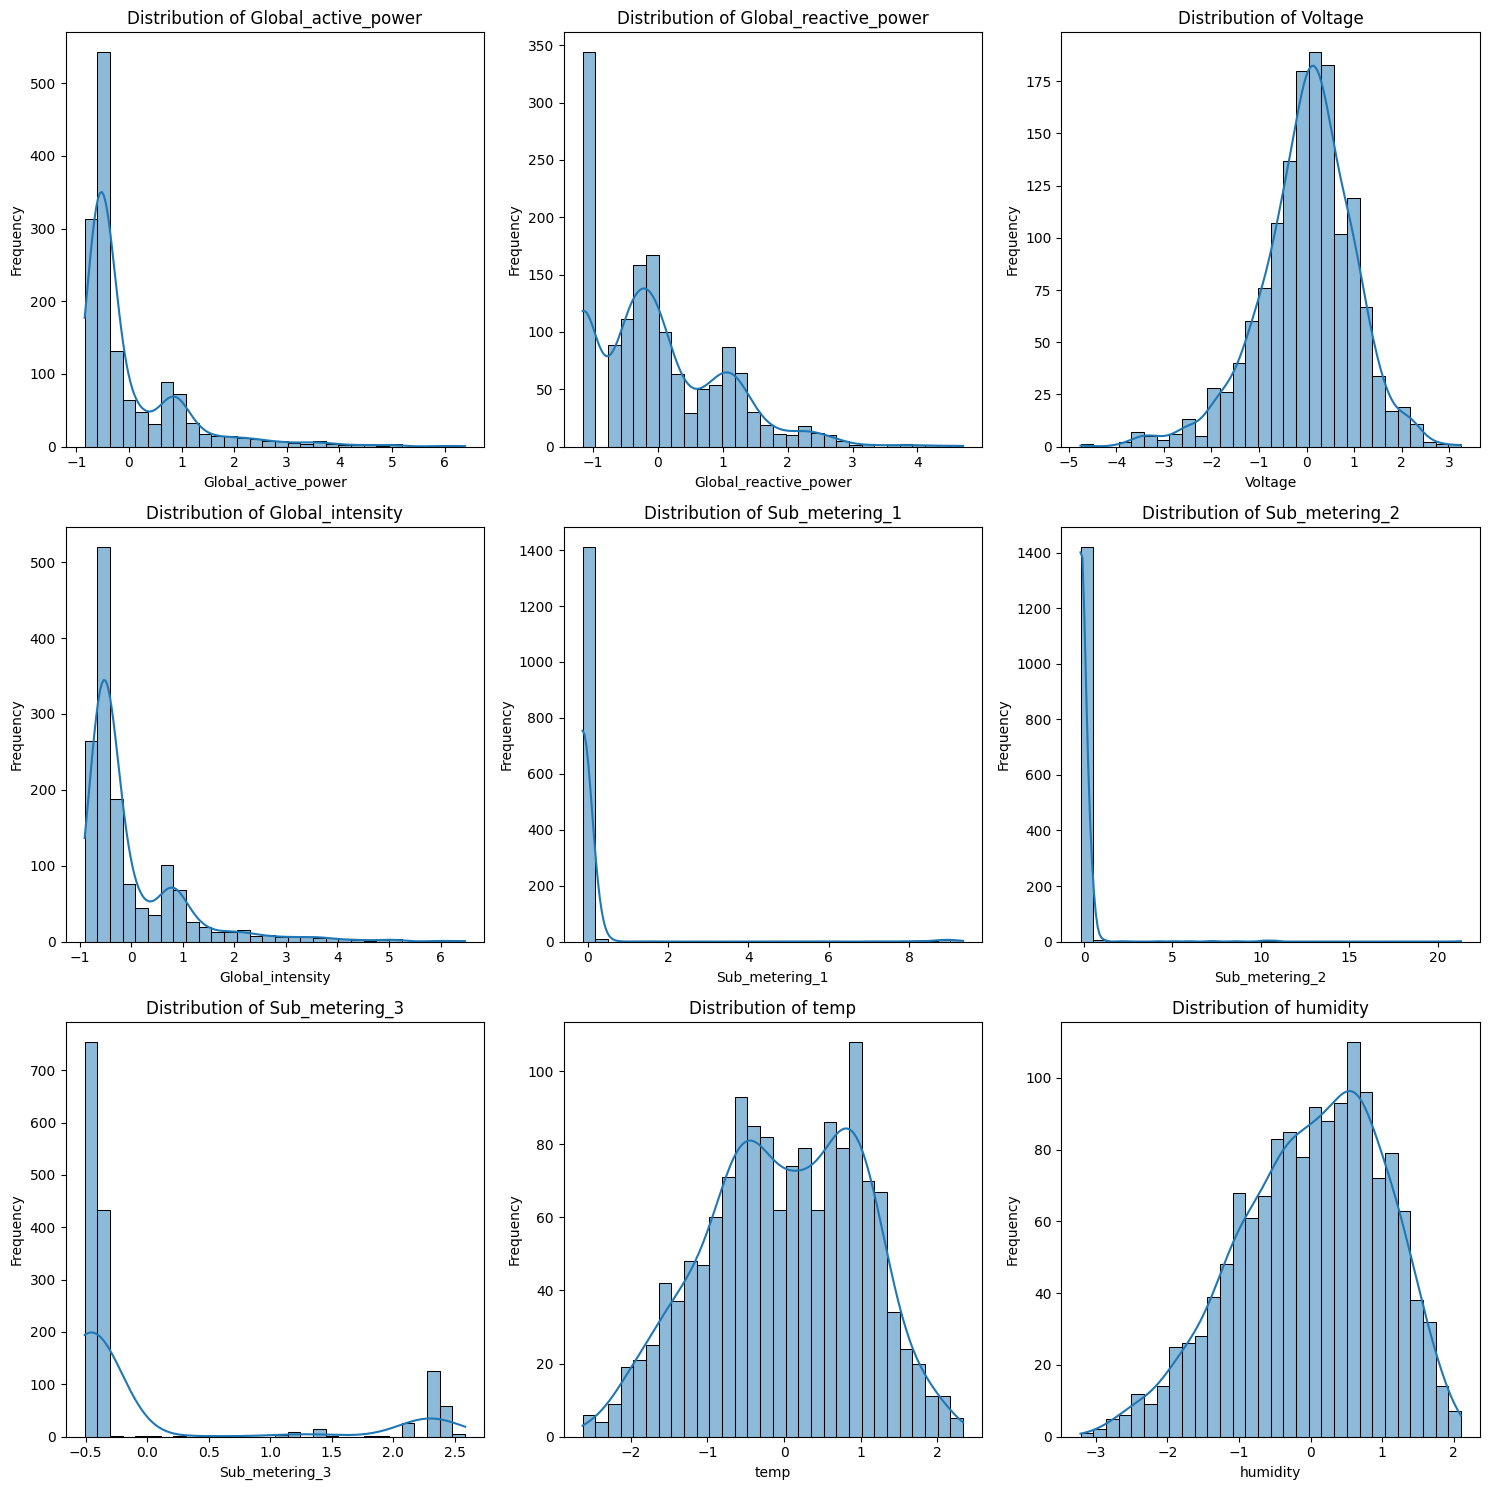

In [29]:
# After seeing the distribution of the variables, we can see that some variables are not normally distributed.
#we can apply standardization or log transformation to make them more normally distributed.
# Standardization function
def log_transform(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    for column in numeric_columns:
        if df[column].min() > 0:  # Log transform only if all values are positive
            df[column] = np.log(df[column])
    return df

log_df =log_transform(df)
# Plot the distribution of the variables after log transformation
plot_variable_distributions(log_df)

In [30]:
log_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
datetime,,,,,,,,,,,,,,,,,,
2006-12-17,0.375815,0.358074,0.026106,0.379038,-0.124584,0.378112,-0.506725,-1.281313,1.587349,False,False,False,False,True,False,False,False,False
2006-12-18,-0.591567,0.099056,1.259498,-0.596744,-0.124584,0.378112,-0.506725,-1.211411,1.278682,False,False,False,False,True,False,False,False,False
2006-12-19,-0.419812,1.254675,-0.526052,-0.352799,-0.124584,0.087210,-0.506725,-1.514322,0.532736,False,True,False,False,False,False,False,False,False
2006-12-20,0.097977,-0.578377,1.044372,0.074106,-0.124584,-0.203692,-0.506725,-1.470827,-0.024580,False,True,False,False,False,False,False,False,False
2006-12-21,1.348249,0.318225,0.305770,1.354821,-0.124584,-0.203692,2.274364,-1.143061,0.318384,False,True,False,False,False,False,False,False,False


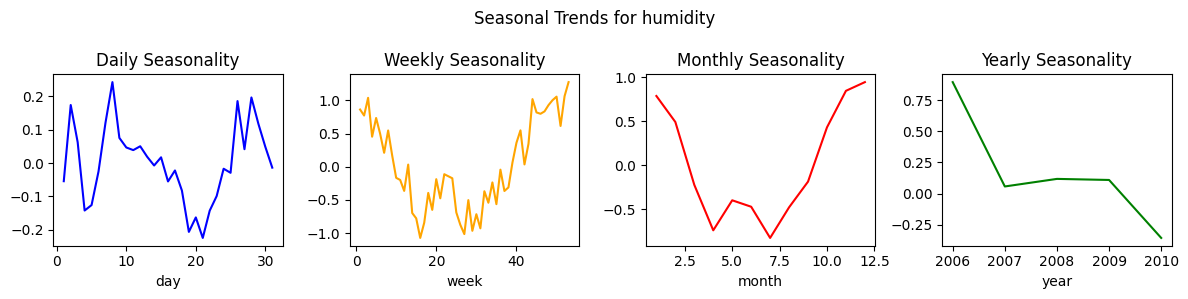

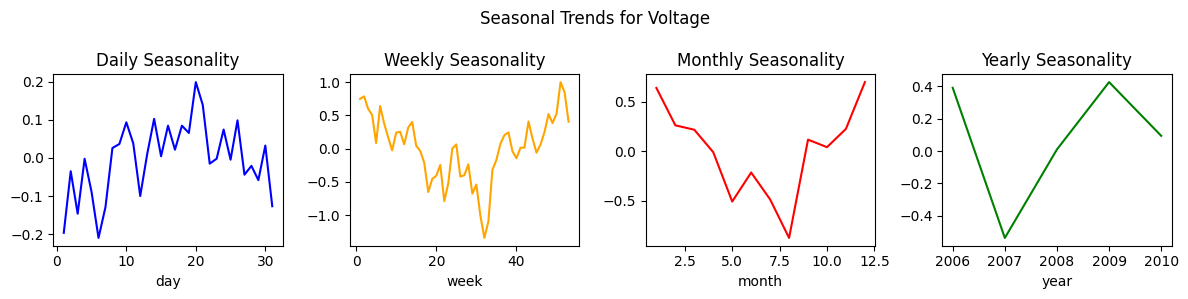

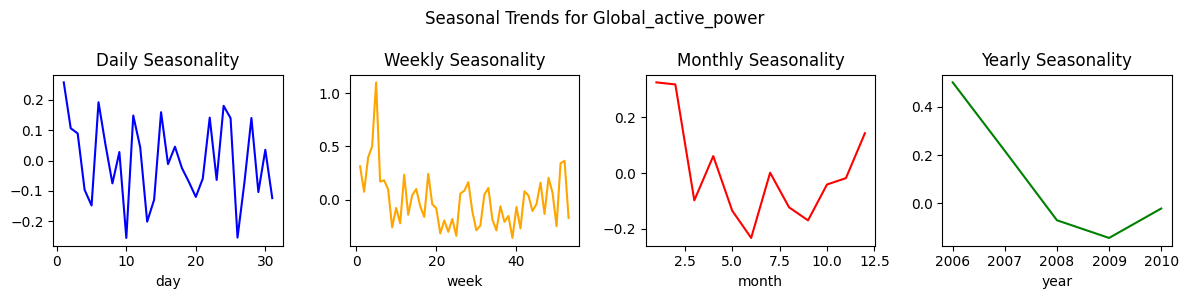

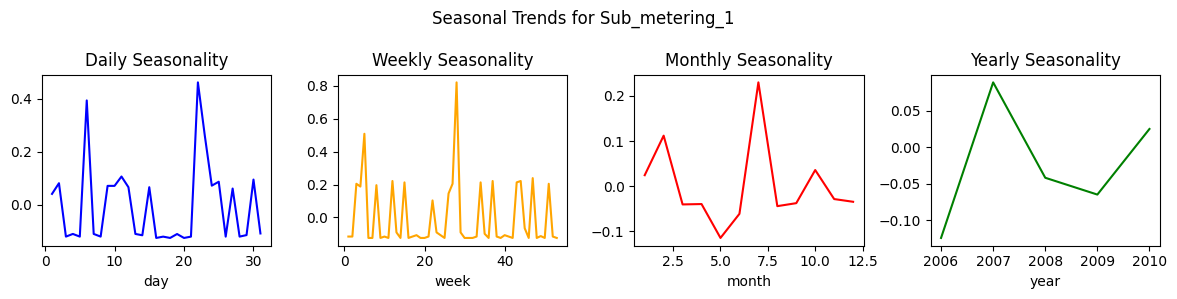

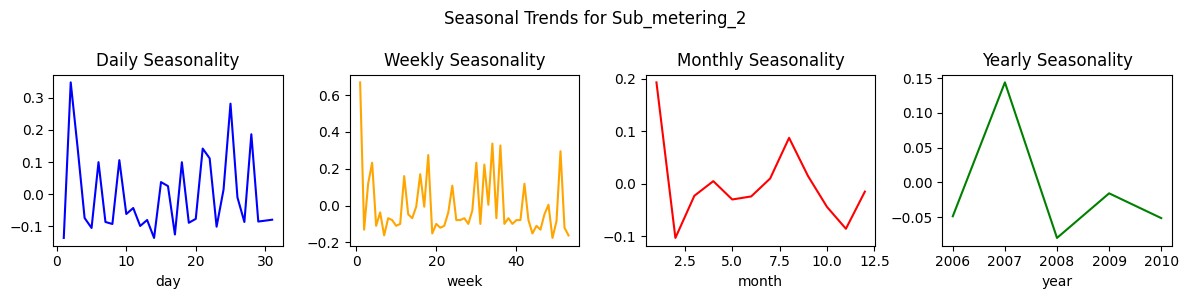

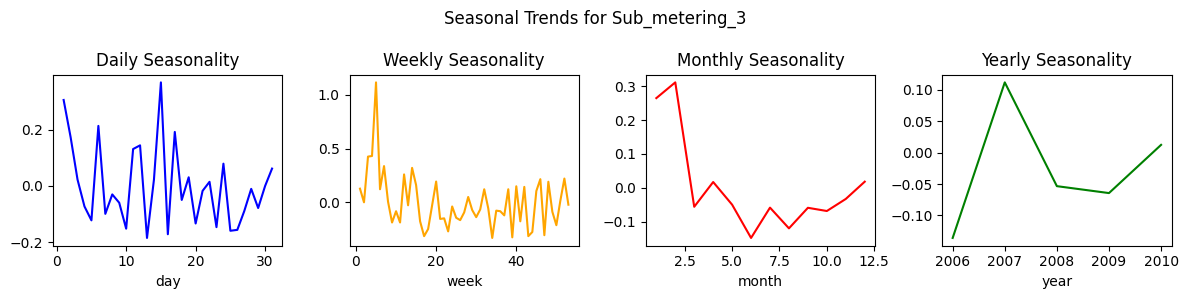

In [33]:
# Seasonality Checks(Daily,Weekly, Yearly) and plot all three seasonal trends for each variable in a row
def plot_seasonal_trends(df, column):
    df['day'] = df.index.day
    df['week'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['year'] = df.index.year
    daily_seasonality = df.groupby('day')[column].mean()
    weekly_seasonality= df.groupby('week')[column].mean()
    monthly_seasonality = df.groupby('month')[column].mean()
    yearly_seasonality = df.groupby('year')[column].mean()

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    daily_seasonality.plot(ax=axs[0], title='Daily Seasonality', color='blue')
    weekly_seasonality.plot(ax=axs[1], title='Weekly Seasonality', color='orange')
    monthly_seasonality.plot(ax=axs[2], title='Monthly Seasonality', color='red')
    yearly_seasonality.plot(ax=axs[3], title='Yearly Seasonality', color='green')
    fig.suptitle(f'Seasonal Trends for {column}')
   

    plt.tight_layout()
    plt.show()

plot_seasonal_trends(log_df, 'humidity')
plot_seasonal_trends(log_df, 'Voltage')
plot_seasonal_trends(log_df, 'Global_active_power')
plot_seasonal_trends(log_df, 'Sub_metering_1')
plot_seasonal_trends(log_df, 'Sub_metering_2')
plot_seasonal_trends(log_df, 'Sub_metering_3')


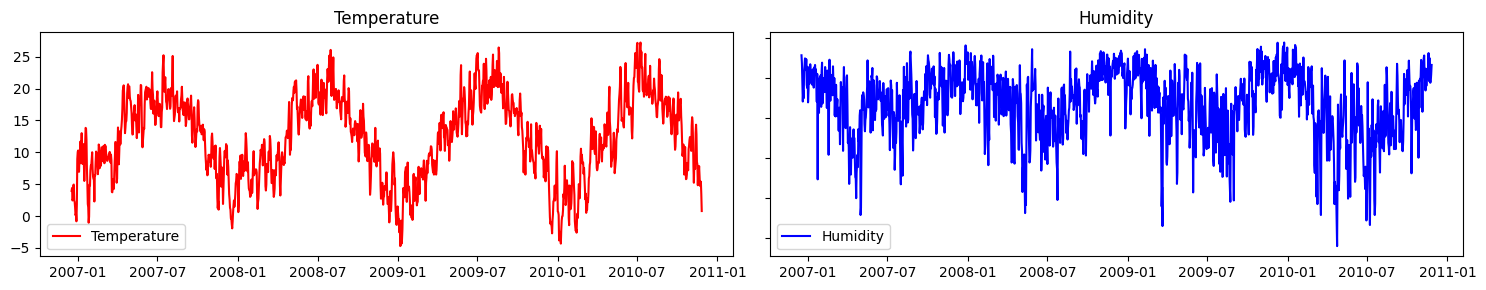

In [ ]:
# Environmental factors over time (Temperature and Humidity)
def plot_environmental_factors(df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    axs[0].plot(df.index, df['temp'], label='Temperature', color='red')
    axs[0].set_title('Temperature')
    axs[1].plot(df.index, df['humidity'], label='Humidity', color='blue')
    axs[1].set_title('Humidity')

    for ax in axs.flat:
        ax.label_outer()
        ax.legend()

    plt.tight_layout()
    plt.show()
    
plot_environmental_factors(df)

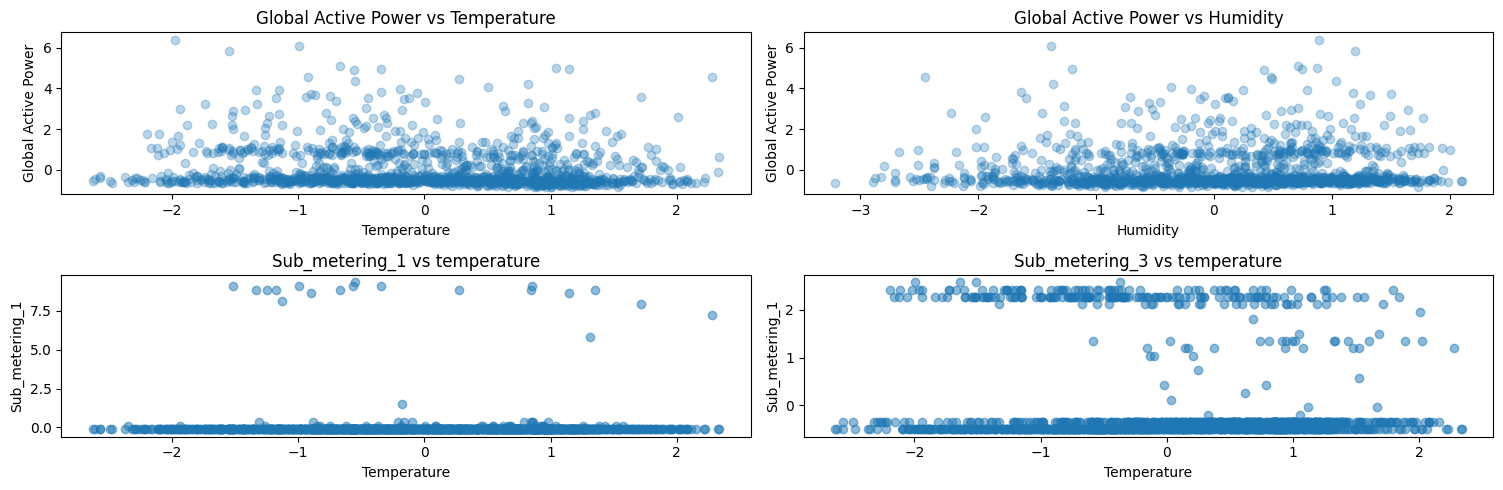

In [34]:
# Check how does the Global Active Power change with respect to the environmental factors
def plot_global_active_power_vs_environment(df):
    fig, axs = plt.subplots(2, 2, figsize=(15, 5))
    axs[0,0].scatter(df['temp'], df['Global_active_power'], alpha=0.3)
    axs[0,0].set_title('Global Active Power vs Temperature')
    axs[0,0].set_xlabel('Temperature')
    axs[0,0].set_ylabel('Global Active Power')

    axs[0,1].scatter(df['humidity'], df['Global_active_power'], alpha=0.3)
    axs[0,1].set_title('Global Active Power vs Humidity')
    axs[0,1].set_xlabel('Humidity')
    axs[0,1].set_ylabel('Global Active Power')
    
    axs[1,0].scatter(df['temp'], df['Sub_metering_1'], alpha=0.5)
    axs[1,0].set_title('Sub_metering_1 vs temperature')
    axs[1,0].set_xlabel('Temperature')
    axs[1,0].set_ylabel('Sub_metering_1')
    
    axs[1,1].scatter(df['temp'], df['Sub_metering_3'], alpha=0.5)
    axs[1,1].set_title('Sub_metering_3 vs temperature')
    axs[1,1].set_xlabel('Temperature')
    axs[1,1].set_ylabel('Sub_metering_1')

    plt.tight_layout()  
    plt.show()

plot_global_active_power_vs_environment(df)


In [61]:
# Visualize the energy consumption over time
def energy_consumption_over_time(df):
    for column in ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','temp', 'humidity', 'Voltage', 'Global_reactive_power']:
        fig = px.line(df, x=df.index, y=column, 
                      title=f'{column} Over Time')
        fig.update_layout(xaxis_title='Date', 
                          yaxis_title=f'{column} (kilowatts)',
                          template='plotly_white')
        fig.show()
energy_consumption_over_time(df)


=== Stationarity Test Results for Original Series ===
ADF Test p-value: -6.048225
ADF Critical Values: {'1%': -3.4349634933241084, '5%': -2.8635775363009244, '10%': -2.5678547733584605}
Series is STATIONARY


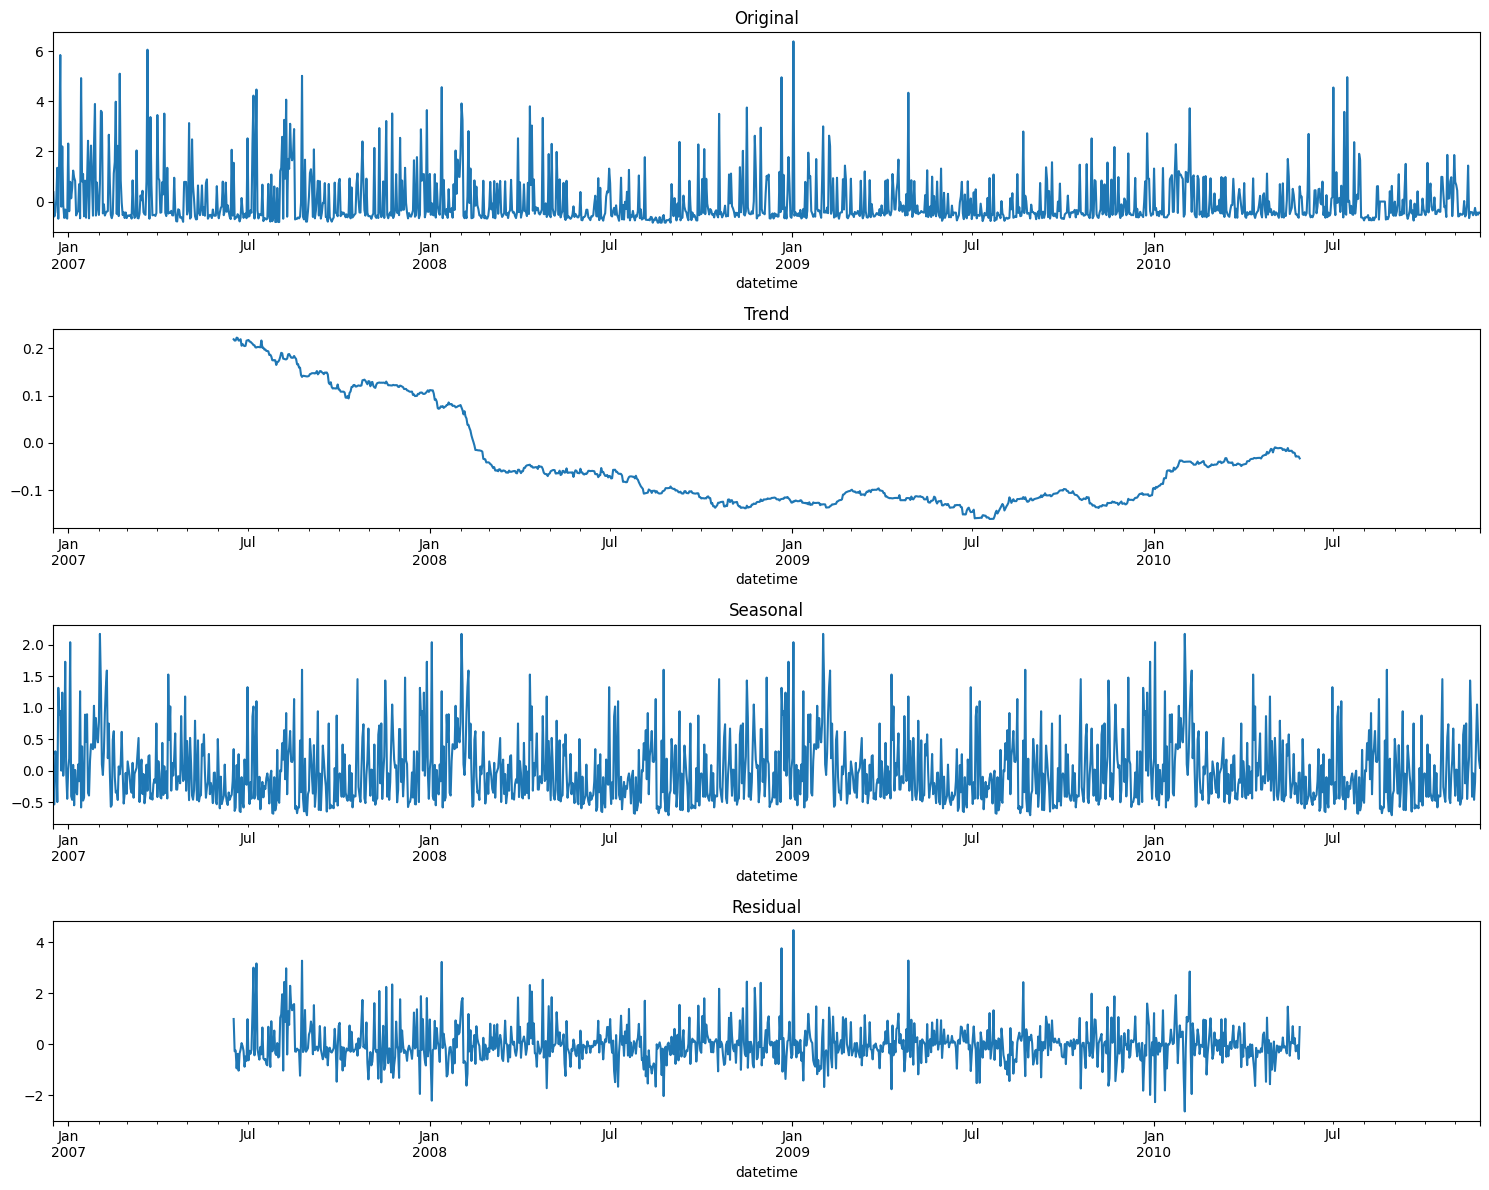

In [35]:

def check_stationarity(timeseries, title):
    """Comprehensive stationarity testing"""
    print(f'\n=== Stationarity Test Results for {title} ===')
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Test p-value: {adf_result[0]:.6f}')
    print(f'ADF Critical Values: {adf_result[4]}')
    
    
    # Interpretation
    adf_stationary = adf_result[1] < 0.05
    
    if adf_stationary:
        print("Series is STATIONARY")
    elif not adf_stationary:
        print("Series is NON-STATIONARY - differencing may be needed")
    else:
        print("Mixed results - further investigation needed")
    
    return adf_stationary

# Test original series
is_stationary = check_stationarity(df['Global_active_power'], 'Original Series')

# If not stationary, apply differencing
if not is_stationary:
    df['power_diff'] = df['Global_active_power'].diff()
    df['power_diff2'] = df['power_diff'].diff()
    
    check_stationarity(df['power_diff'].dropna(), 'First Difference')
    check_stationarity(df['power_diff2'].dropna(), 'Second Difference')

# Seasonal decomposition
decomposition = seasonal_decompose(df['Global_active_power'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [36]:
# check stationarity of the time series
def check_stationarity(series):
    result = adfuller(series)
    print(f'Checking stationarity for {series.name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")
    print(20* '-')

check_stationarity(df['Global_active_power'])
check_stationarity(df['Sub_metering_1'])
check_stationarity(df['Sub_metering_2'])
check_stationarity(df['Sub_metering_3'])

Checking stationarity for Global_active_power:
ADF Statistic: -6.048224797037368
p-value: 1.2963186281493117e-07
The series is stationary.
--------------------
Checking stationarity for Sub_metering_1:
ADF Statistic: -38.51352578154837
p-value: 0.0
The series is stationary.
--------------------
Checking stationarity for Sub_metering_2:
ADF Statistic: -6.9069549823448675
p-value: 1.2402027873633756e-09
The series is stationary.
--------------------
Checking stationarity for Sub_metering_3:
ADF Statistic: -12.265318639131683
p-value: 8.887649698869799e-23
The series is stationary.
--------------------


All four time series (Global_active_power, Sub_metering_1, Sub_metering_2, and Sub_metering_3) have very low ADF statistics and extremely small p-values (close to zero).

This means that all the series are stationary, so their statistical properties (like mean and variance) do not shift over time.

The ADF statistic is a measure of stationarity: lower values (more negative) typically indicate stronger evidence of stationarity.

The p-value tells us whether we reject the null hypothesis (which assumes the series is non-stationary). If the p-value is below a common threshold (0.05 or 0.01), we reject the null hypothesis, meaning the series is stationary.

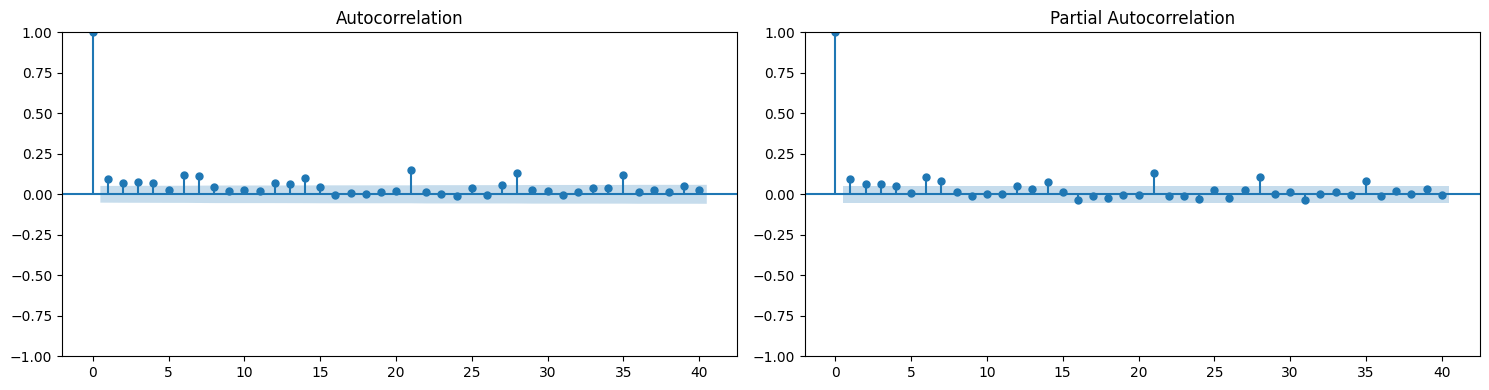

In [37]:
# Plot ACF and PACF
def plot_acf_pacf(df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(df['Global_active_power'].dropna(), ax=axs[0], lags=40)
    plot_pacf(df['Global_active_power'].dropna(), ax=axs[1], lags=40)
    plt.tight_layout()
    plt.show()
plot_acf_pacf(df)


The ACF plot shows that most lag values hover close to zero and stay within the confidence interval. This indicates that the series does not have strong long-term dependencies.

The PACF plot(Right): shows that there are no sharp cut-offs at a specific lag, meaning no clear autoregressive structure dominates. Its  Helps determine the direct relationship between a given lag and the current value while removing the influence of earlier lags.

Autocorrelation Plot (left): Shows how current values are correlated with past values (lags).

lag:
The first lag is always 1.00 because a value is always perfectly correlated with itself. If the vertical lines (bars) exceed the shaded confidence interval, those lags have significant autocorrelation. If the bars decay gradually, this suggests a possible trend or seasonality in the data.

In [38]:

# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
df['is_holiday'] = pd.Series(df.index.date, index=df.index).isin(holiday_dates).astype(int)

df['poweer_1stdiff'] = df['Global_active_power'].diff()

# Create lag features
for lag in [1, 7, 30]:
    df[f'power_lag_{lag}'] = df['Global_active_power'].shift(lag)

# Rolling statistics
window_sizes = [7, 30]
for window in window_sizes:
    df[f'power_rolling_mean_{window}'] = df['Global_active_power'].rolling(window=window).mean()
    df[f'power_rolling_std_{window}'] = df['Global_active_power'].rolling(window=window).std()



# Remove initial NaN values created by lag features
df = df.dropna()

print(f"Feature engineered dataset shape: {df.shape}")
print(f"New features created: {df.shape[1] - 11}")

Feature engineered dataset shape: (1411, 35)
New features created: 24


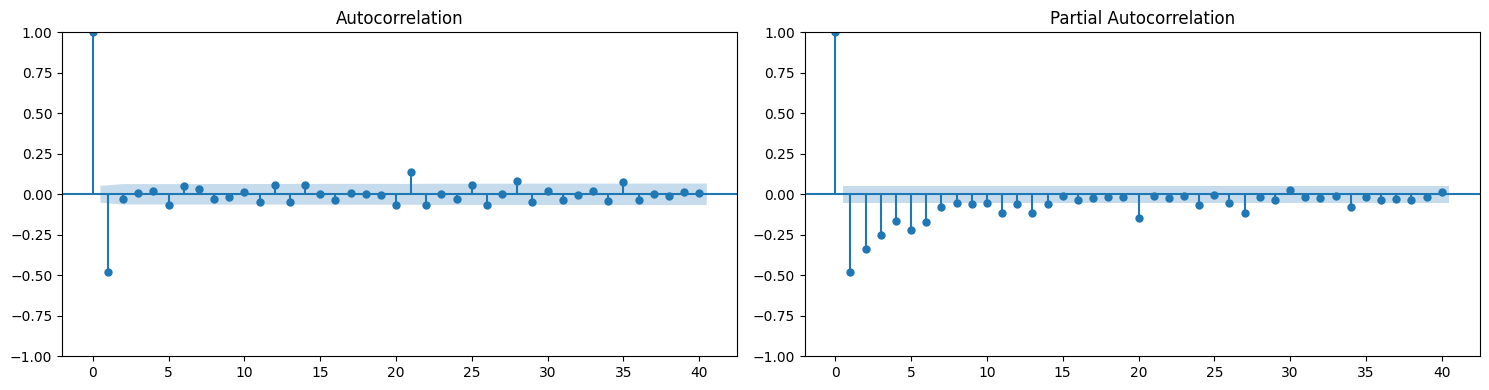

In [42]:
def plot_acf_pacf(df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(df['poweer_1stdiff'].dropna(), ax=axs[0], lags=40)
    plot_pacf(df['poweer_1stdiff'].dropna(), ax=axs[1], lags=40)
    plt.tight_layout()
    plt.show()
plot_acf_pacf(df)

In [43]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions_Overcast,...,is_weekend,is_holiday,poweer_1stdiff,power_lag_1,power_lag_7,power_lag_30,power_rolling_mean_7,power_rolling_std_7,power_rolling_mean_30,power_rolling_std_30
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-16,1.103246,0.477621,0.133669,1.354821,-0.124584,5.905244,-0.506725,-0.659957,1.055755,False,...,0,0,0.300570,0.802676,-0.551154,0.375815,0.863656,1.921380,0.635552,1.580371
2007-01-17,-0.586515,-0.020491,0.226891,-0.596744,-0.124584,-0.203692,-0.506725,-0.124037,1.218663,False,...,0,0,-1.689761,1.103246,-0.432441,-0.591567,0.841645,1.939499,0.635720,1.580236
2007-01-18,0.835511,-0.120114,0.757536,0.744957,-0.124584,-0.203692,2.428869,0.254990,0.858551,False,...,0,0,1.422026,-0.586515,-0.381925,-0.419812,1.015565,1.864632,0.677564,1.567894
2007-01-19,-0.642083,-1.156187,-0.253559,-0.657731,-0.124584,-0.203692,-0.506725,0.237903,1.055755,False,...,0,0,-1.477594,0.835511,0.694066,0.097977,0.824686,1.968524,0.652896,1.583076
2007-01-20,0.792572,-1.156187,-0.396976,0.744957,-0.124584,-0.203692,-0.506725,-0.029280,0.549884,False,...,1,0,1.434655,-0.642083,-0.664815,1.348249,1.032884,1.858741,0.634373,1.577902


### Arima model

In [ ]:
import optuna
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

class ARIMAOptimizer:
    def __init__(self, data, test_size=0.40):
        self.data = data
        self.train_size = int(len(data) * (1 - test_size))
        self.train_data = data[:self.train_size]
        self.test_data = data[self.train_size:]
        self.best_model = None
        self.best_params = None
        
    def objective(self, trial):
        # Hyperparameter search space
        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 1)
        q = trial.suggest_int('q', 0, 3)
        
        try:
            model = ARIMA(self.train_data, order=(p, d, q))
            fitted_model = model.fit()
            
            # Cross-validation using time series split
            tscv = TimeSeriesSplit(n_splits=3)
            cv_scores = []
            
            for train_idx, val_idx in tscv.split(self.train_data):
                train_fold = self.train_data.iloc[train_idx]
                val_fold = self.train_data.iloc[val_idx]
                
                try:
                    model_fold = ARIMA(train_fold, order=(p, d, q))
                    fitted_fold = model_fold.fit()
                    forecast = fitted_fold.forecast(steps=len(val_fold))
                    mse = mean_squared_error(val_fold, forecast)
                    cv_scores.append(mse)
                except:
                    cv_scores.append(float('inf'))
            
            return np.mean(cv_scores)
            
        except Exception as e:
            return float('inf')
    
    def optimize(self, n_trials=20):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"Best ARIMA parameters: {self.best_params}")
        
        # Fit final model
        p, d, q = self.best_params['p'], self.best_params['d'], self.best_params['q']
        self.best_model = ARIMA(self.train_data, order=(p, d, q)).fit()
        
        return self.best_model, self.best_params

# Optimize ARIMA
arima_optimizer = ARIMAOptimizer(df['Global_active_power'])
arima_model, arima_params = arima_optimizer.optimize(n_trials=20)

# Generate forecasts
arima_forecast = arima_model.forecast(steps=len(arima_optimizer.test_data))
arima_mae = mean_absolute_error(arima_optimizer.test_data, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(arima_optimizer.test_data, arima_forecast))

print(f"ARIMA Performance - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}")

[I 2025-05-27 14:38:54,642] A new study created in memory with name: no-name-30816ef6-a303-4760-a34f-79b443fa3ba1
[I 2025-05-27 14:38:56,325] Trial 0 finished with value: 1.0495888197456347 and parameters: {'p': 3, 'd': 0, 'q': 2}. Best is trial 0 with value: 1.0495888197456347.
[I 2025-05-27 14:38:57,502] Trial 1 finished with value: 1.0680013253145564 and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 0 with value: 1.0495888197456347.
[I 2025-05-27 14:38:58,065] Trial 2 finished with value: 1.2045634843856532 and parameters: {'p': 3, 'd': 1, 'q': 1}. Best is trial 0 with value: 1.0495888197456347.
[I 2025-05-27 14:38:58,370] Trial 3 finished with value: 1.043582949802353 and parameters: {'p': 3, 'd': 0, 'q': 0}. Best is trial 3 with value: 1.043582949802353.
[I 2025-05-27 14:38:59,159] Trial 4 finished with value: 1.0496242064210448 and parameters: {'p': 3, 'd': 0, 'q': 1}. Best is trial 3 with value: 1.043582949802353.
[I 2025-05-27 14:38:59,352] Trial 5 finished with value: 1.

Best ARIMA parameters: {'p': 2, 'd': 0, 'q': 0}
ARIMA Performance - MAE: 0.6123, RMSE: 0.7711


In [96]:
# Fit ARIMA model using statsmodels'

def fit_arima_model(df, order):
    """Fit an ARIMA model to the data."""
    model = ARIMA(df['poweer_1stdiff'], order=order,exog=df[['temp','humidity','power_lag_1', 'power_lag_7','power_lag_30' ]])
    model_fit = model.fit()
    return model_fit

model=fit_arima_model(df, (2,0, 2))
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         poweer_1stdiff   No. Observations:                 1411
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1946.871
Date:                Tue, 27 May 2025   AIC                           3915.742
Time:                        14:56:05   BIC                           3973.515
Sample:                    01-16-2007   HQIC                          3937.330
                         - 11-26-2010                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0103      0.067     -0.154      0.877      -0.141       0.120
temp            -0.1027      0.040     -2.577      0.010      -0.181      -0.025
humidity        -0.0284      0.035     -0.807      0.419      -0.097       0.041
power_lag_1     -0.9865      0.032    -30.425      0.000      -1.050      -0.923
power_lag_7      0.0658      0.023      2.840      0.005       0.020       0.111
power_lag_30    -0.0024      0.024     -0.100      0.920      -0.049       0.044
ar.L1           -0.0697      0.161     -0.433      0.665      -0.385       0.246
ar.L2            0.9027      0.141      6.398      0.000       0.626       1.179
ma.L1            0.1190      0.161      0.738      0.461      -0.197       0.435
ma.L2           -0.8557      0.136     -6.278      0.000      -1.123      -0.589
sigma2           0.9246      0.027     34.180      0.000       0.872       0.978
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4238.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

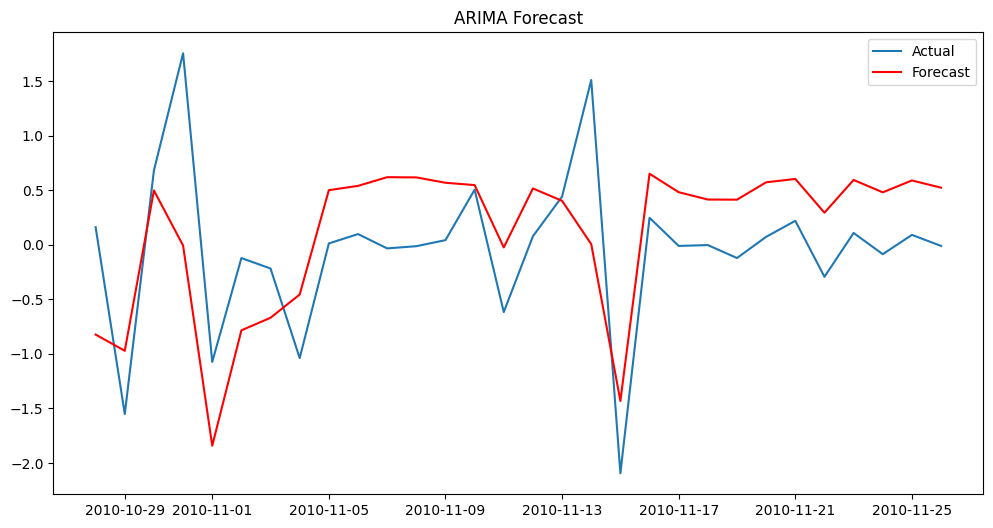

In [97]:
# forecasting with ARIMA
def forecast_arima(model, steps):
    """Generate forecasts using the fitted ARIMA model."""
    forecast = model.forecast(
        steps=steps,
        exog=df[['temp','humidity','power_lag_1','power_lag_7','power_lag_30']].iloc[-steps:]
    )
    return forecast

forecast = forecast_arima(model, steps=arima_optimizer.train_size)
plt.figure(figsize=(12, 6))
plt.plot(df.index[-30:], df['poweer_1stdiff'].iloc[-30:], label='Actual')
plt.plot(df.index[-30:], forecast[-30:], label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
model.accuracy_stats = {
    'MAE': mean_absolute_error(df['power_1diff'].iloc[-arima_optimizer.train_size:], forecast),
    'RMSE': np.sqrt(mean_squared_error(df['power_1diff'].iloc[-arima_optimizer.train_size:], forecast)),
    'R2': r2_score(df['power_1diff'].iloc[-arima_optimizer.train_size:], forecast)
}
print(f"ARIMA Model Accuracy: {model.accuracy_stats}")


ARIMA Model Accuracy: {'MAE': 0.6195630311072645, 'RMSE': 0.7630107078620497, 'R2': 0.37888831061053374}


In [29]:
df['residuals'] = model.resid

In [30]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions_Overcast,...,is_holiday,power_lag_1,power_lag_7,power_lag_30,power_rolling_mean_7,power_rolling_std_7,power_rolling_mean_30,power_rolling_std_30,power_1diff,residuals
datetime,,,,,,,,,,,,,,,,,,,,,
2007-02-15,0.356,0.136,243.95,1.6,0.0,0.0,0.0,6.56,75.9,False,...,0,0.222,0.394,1.620,0.858857,0.961883,1.237533,1.152501,0.134,25.159741
2007-02-16,1.636,0.116,243.92,6.8,0.0,0.0,19.0,7.50,68.7,False,...,0,0.356,0.430,0.282,1.031143,0.980099,1.282667,1.140238,1.280,1.138176
2007-02-17,1.996,0.344,241.25,8.4,0.0,1.0,18.0,11.22,55.4,False,...,0,1.636,0.450,1.408,1.252000,1.001278,1.302267,1.147497,0.360,-0.589262
2007-02-18,3.902,0.086,237.68,16.4,0.0,1.0,0.0,10.94,70.3,False,...,0,1.996,2.858,0.238,1.401143,1.310401,1.424400,1.222831,1.906,0.836335
2007-02-19,0.356,0.190,242.56,1.6,0.0,1.0,0.0,7.50,89.1,False,...,0,3.902,1.370,1.374,1.256286,1.369146,1.390467,1.238305,-3.546,-4.339287


### Sarima Model

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

class SARIMAOptimizer:
    def __init__(self, data, test_size=0.2):
        self.data = data
        self.train_size = int(len(data) * (1 - test_size))
        self.train_data = data[:self.train_size]
        self.test_data = data[self.train_size:]
        self.best_model = None
        self.best_params = None
        
    def objective(self, trial):
        # SARIMA hyperparameters
        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 3)
        P = trial.suggest_int('P', 0, 2)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 2)
        s = trial.suggest_categorical('s', [7, 30, 365])  # Weekly, monthly, yearly
        
        try:
            model = SARIMAX(self.train_data, 
                           order=(p, d, q),
                           seasonal_order=(P, D, Q, s),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            fitted_model = model.fit(disp=False)
            
            # Validation forecast
            val_forecast = fitted_model.forecast(steps=50)  # Short validation
            val_actual = self.train_data[-50:]
            mse = mean_squared_error(val_actual, val_forecast)
            
            return mse
            
        except Exception as e:
            return float('inf')
    
    def optimize(self, n_trials=10):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"Best SARIMA parameters: {self.best_params}")
        
        # Fit final model
        p, d, q = self.best_params['p'], self.best_params['d'], self.best_params['q']
        P, D, Q, s = self.best_params['P'], self.best_params['D'], self.best_params['Q'], self.best_params['s']
        
        self.best_model = SARIMAX(self.train_data,
                                 order=(p, d, q),
                                 seasonal_order=(P, D, Q, s),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit(disp=False)
        
        return self.best_model, self.best_params

# Optimize SARIMA
sarima_optimizer = SARIMAOptimizer(df['Global_active_power'])
sarima_model, sarima_params = sarima_optimizer.optimize(n_trials=10)

# Generate forecasts
sarima_forecast = sarima_model.forecast(steps=len(sarima_optimizer.test_data))
sarima_mae = mean_absolute_error(sarima_optimizer.test_data, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(sarima_optimizer.test_data, sarima_forecast))

print(f"SARIMA Performance - MAE: {sarima_mae:.4f}, RMSE: {sarima_rmse:.4f}")

NameError: name 'df' is not defined

### SARIMAX Model


In [ ]:
class SARIMAXOptimizer:
    def __init__(self, data, exog_vars, test_size=0.2):
        self.data = data
        self.exog_vars = exog_vars
        self.train_size = int(len(data) * (1 - test_size))
        self.train_data = data[:self.train_size]
        self.test_data = data[self.train_size:]
        self.train_exog = exog_vars[:self.train_size]
        self.test_exog = exog_vars[self.train_size:]
        self.best_model = None
        self.best_params = None
        
    def objective(self, trial):
        # SARIMAX hyperparameters
        p = trial.suggest_int('p', 0, 2)
        d = trial.suggest_int('d', 0, 1)
        q = trial.suggest_int('q', 0, 2)
        P = trial.suggest_int('P', 0, 1)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 1)
        s = trial.suggest_categorical('s', [7, 30])
        
        try:
            model = SARIMAX(self.train_data,
                           exog=self.train_exog,
                           order=(p, d, q),
                           seasonal_order=(P, D, Q, s),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            fitted_model = model.fit(disp=False)
            
            # Validation
            val_steps = 30
            val_forecast = fitted_model.forecast(steps=val_steps, 
                                               exog=self.train_exog[-val_steps:])
            val_actual = self.train_data[-val_steps:]
            mse = mean_squared_error(val_actual, val_forecast)
            
            return mse
            
        except Exception as e:
            return float('inf')
    
    def optimize(self, n_trials=30):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"Best SARIMAX parameters: {self.best_params}")
        
        # Fit final model
        p, d, q = self.best_params['p'], self.best_params['d'], self.best_params['q']
        P, D, Q, s = self.best_params['P'], self.best_params['D'], self.best_params['Q'], self.best_params['s']
        
        self.best_model = SARIMAX(self.train_data,
                                 exog=self.train_exog,
                                 order=(p, d, q),
                                 seasonal_order=(P, D, Q, s),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit(disp=False)
        
        return self.best_model, self.best_params

# Select most important external variables based on correlation analysis
important_vars = ['temp', 'humidity', 'Sub_metering_3', 'Sub_metering_1', 'Voltage']
exog_data = df[important_vars]

# Optimize SARIMAX
sarimax_optimizer = SARIMAXOptimizer(df['Global_active_power'], exog_data)
sarimax_model, sarimax_params = sarimax_optimizer.optimize(n_trials=30)

# Generate forecasts
sarimax_forecast = sarimax_model.forecast(steps=len(sarimax_optimizer.test_data),
                                         exog=sarimax_optimizer.test_exog)
sarimax_mae = mean_absolute_error(sarimax_optimizer.test_data, sarimax_forecast)
sarimax_rmse = np.sqrt(mean_squared_error(sarimax_optimizer.test_data, sarimax_forecast))

print(f"SARIMAX Performance - MAE: {sarimax_mae:.4f}, RMSE: {sarimax_rmse:.4f}")

### RNN/LSTM Model 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

class RNNOptimizer:
    def __init__(self, data, features, test_size=0.2, sequence_length=30):
        self.sequence_length = sequence_length
        self.scaler_target = MinMaxScaler()
        self.scaler_features = MinMaxScaler()
        
        # Scale data
        target_scaled = self.scaler_target.fit_transform(data.values.reshape(-1, 1))
        features_scaled = self.scaler_features.fit_transform(features.values)
        
        # Create sequences
        self.X, self.y = self.create_sequences(features_scaled, target_scaled.flatten())
        
        # Split data
        train_size = int(len(self.X) * (1 - test_size))
        self.X_train, self.X_test = self.X[:train_size], self.X[train_size:]
        self.y_train, self.y_test = self.y[:train_size], self.y[train_size:]
        
    def create_sequences(self, features, target):
        X, y = [], []
        for i in range(self.sequence_length, len(features)):
            X.append(features[i-self.sequence_length:i])
            y.append(target[i])
        return np.array(X), np.array(y)
    
    def create_model(self, trial):
        model = Sequential()
        
        # Architecture hyperparameters
        n_layers = trial.suggest_int('n_layers', 1, 3)
        units = trial.suggest_categorical('units', [32, 64, 128])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        
        # First layer
        if trial.suggest_categorical('layer_type', ['LSTM', 'GRU']) == 'LSTM':
            model.add(LSTM(units, return_sequences=n_layers > 1, 
                          input_shape=(self.sequence_length, self.X_train.shape[2])))
        else:
            model.add(GRU(units, return_sequences=n_layers > 1,
                         input_shape=(self.sequence_length, self.X_train.shape[2])))
        
        model.add(Dropout(dropout_rate))
        
        # Additional layers
        for i in range(1, n_layers):
            if trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) == 'LSTM':
                model.add(LSTM(units // (i + 1), return_sequences=i < n_layers - 1))
            else:
                model.add(GRU(units // (i + 1), return_sequences=i < n_layers - 1))
            model.add(Dropout(dropout_rate))
        
        # Output layer
        model.add(Dense(1))
        
        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        return model
    
    def objective(self, trial):
        model = self.create_model(trial)
        
        # Training hyperparameters
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        epochs = trial.suggest_int('epochs', 10, 20)
        
        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            self.X_train, self.y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Get validation loss
        val_loss = min(history.history['val_loss'])
        return val_loss
    
    def optimize(self, n_trials=20):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"Best RNN parameters: {self.best_params}")
        
        # Train final model
        self.best_model = self.create_model(study.best_trial)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        self.best_model.fit(
            self.X_train, self.y_train,
            validation_split=0.2,
            batch_size=self.best_params['batch_size'],
            epochs=self.best_params['epochs'],
            callbacks=[early_stopping],
            verbose=1
        )
        
        return self.best_model, self.best_params

# Prepare features for RNN
rnn_features = df[['temp', 'humidity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                   'Voltage', 'Global_reactive_power', 'power_lag_1', 'power_rolling_mean_7']]

# Optimize RNN
rnn_optimizer = RNNOptimizer(df['Global_active_power'], rnn_features)
rnn_model, rnn_params = rnn_optimizer.optimize(n_trials=20)

# Generate forecasts
rnn_predictions = rnn_model.predict(rnn_optimizer.X_test)
rnn_predictions_scaled = rnn_optimizer.scaler_target.inverse_transform(rnn_predictions)
rnn_actual_scaled = rnn_optimizer.scaler_target.inverse_transform(rnn_optimizer.y_test.reshape(-1, 1))

rnn_mae = mean_absolute_error(rnn_actual_scaled, rnn_predictions_scaled)
rnn_rmse = np.sqrt(mean_squared_error(rnn_actual_scaled, rnn_predictions_scaled))

print(f"RNN Performance - MAE: {rnn_mae:.4f}, RMSE: {rnn_rmse:.4f}")

### Prophet Model 

In [ ]:
from prophet import Prophet
import pandas as pd

class ProphetOptimizer:
    def __init__(self, data, test_size=0.2):
        # Prepare data for Prophet
        self.df_prophet = pd.DataFrame({
            'ds': data.index,
            'y': data.values
        })
        
        train_size = int(len(self.df_prophet) * (1 - test_size))
        self.train_data = self.df_prophet[:train_size]
        self.test_data = self.df_prophet[train_size:]
        self.best_model = None
        self.best_params = None
        
    def objective(self, trial):
        # Prophet hyperparameters
        changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
        seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
        holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True)
        seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
        
        try:
            model = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                holidays_prior_scale=holidays_prior_scale,
                seasonality_mode=seasonality_mode,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True
            )
            
            # Add custom seasonalities
            model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
            
            model.fit(self.train_data)
            
            # Cross-validation
            val_size = min(30, len(self.train_data) // 4)
            val_train = self.train_data[:-val_size]
            val_test = self.train_data[-val_size:]
            
            model_val = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                holidays_prior_scale=holidays_prior_scale,
                seasonality_mode=seasonality_mode
            )
            model_val.fit(val_train)
            
            future_val = model_val.make_future_dataframe(periods=val_size, freq='D')
            forecast_val = model_val.predict(future_val)
            
            mse = mean_squared_error(val_test['y'], forecast_val['yhat'][-val_size:])
            return mse
            
        except Exception as e:
            return float('inf')
    
    def optimize(self, n_trials=30):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"Best Prophet parameters: {self.best_params}")
        
        # Fit final model
        self.best_model = Prophet(
            changepoint_prior_scale=self.best_params['changepoint_prior_scale'],
            seasonality_prior_scale=self.best_params['seasonality_prior_scale'],
            holidays_prior_scale=self.best_params['holidays_prior_scale'],
            seasonality_mode=self.best_params['seasonality_mode'],
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True
        )
        
        # Add custom seasonalities
        self.best_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        self.best_model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
        
        self.best_model.fit(self.train_data)
        
        return self.best_model, self.best_params

# Optimize Prophet
prophet_optimizer = ProphetOptimizer(df['Global_active_power'])
prophet_model, prophet_params = prophet_optimizer.optimize(n_trials=30)

# Generate forecasts
future = prophet_model.make_future_dataframe(periods=len(prophet_optimizer.test_data), freq='D')
prophet_forecast = prophet_model.predict(future)

prophet_predictions = prophet_forecast['yhat'][-len(prophet_optimizer.test_data):].values
prophet_mae = mean_absolute_error(prophet_optimizer.test_data['y'], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(prophet_optimizer.test_data['y'], prophet_predictions))

print(f"Prophet Performance - MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}")

### Model Performance Comparison

In [ ]:
# Compile results
results = {
    'Model': ['ARIMA', 'SARIMA', 'SARIMAX', 'RNN/LSTM', 'Prophet'],
    'MAE': [arima_mae, sarima_mae, sarimax_mae, rnn_mae, prophet_mae],
    'RMSE': [arima_rmse, sarima_rmse, sarimax_rmse, rnn_rmse, prophet_rmse],
    'Parameters': [arima_params, sarima_params, sarimax_params, rnn_params, prophet_params]
}

results_df = pd.DataFrame(results)
results_df['MAPE'] = (results_df['MAE'] / df['Global_active_power'].mean()) * 100

print("=== MODEL PERFORMANCE COMPARISON ===")
print(results_df.to_string(index=False))

# Best performing model
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"MAE: {results_df.loc[best_model_idx, 'MAE']:.4f}")
print(f"RMSE: {results_df.loc[best_model_idx, 'RMSE']:.4f}")
print(f"MAPE: {results_df.loc[best_model_idx, 'MAPE']:.2f}%")

### Comprehensive Visualization 

In [ ]:
# Create comprehensive visualization
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Model Performance Comparison', 'Forecast vs Actual (Best Model)',
                   'Residual Analysis', 'Feature Importance (SARIMAX)',
                   'Seasonal Components (Prophet)', 'Error Distribution'),
    specs=[[{"type": "bar"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "bar"}],
           [{"colspan": 2}, None]]
)

# Performance comparison
fig.add_trace(go.Bar(
    x=results_df['Model'],
    y=results_df['RMSE'],
    name='RMSE',
    marker_color='lightblue'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=results_df['Model'],
    y=results_df['MAE'],
    name='MAE',
    marker_color='lightcoral',
    yaxis='y2'
), row=1, col=1)

# Best model forecast visualization (using SARIMAX as example)
test_dates = df.index[-len(sarimax_optimizer.test_data):]
fig.add_trace(go.Scatter(
    x=test_dates,
    y=sarimax_optimizer.test_data.values,
    name='Actual',
    line=dict(color='blue')
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=test_dates,
    y=sarimax_forecast,
    name='SARIMAX Forecast',
    line=dict(color='red', dash='dash')
), row=1, col=2)

# Residual analysis
residuals = sarimax_optimizer.test_data.values - sarimax_forecast
fig.add_trace(go.Scatter(
    x=test_dates,
    y=residuals,
    mode='markers',
    name='Residuals',
    marker=dict(color='green')
), row=2, col=1)

# Feature importance (correlation with target)
feature_importance = {
    'temp': -0.1228,
    'humidity': 0.0459,
    'Sub_metering_3': 0.6425,
    'Sub_metering_1': 0.4112,
    'Voltage': -0.3042
}

fig.add_trace(go.Bar(
    x=list(feature_importance.keys()),
    y=list(feature_importance.values()),
    name='Correlation',
    marker_color=['red' if v < 0 else 'green' for v in feature_importance.values()]
), row=2, col=2)

# Error distribution
all_errors = np.concatenate([
    arima_optimizer.test_data.values - arima_forecast,
    sarima_optimizer.test_data.values - sarima_forecast,
    sarimax_optimizer.test_data.values - sarimax_forecast,
    rnn_actual_scaled.flatten() - rnn_predictions_scaled.flatten(),
    prophet_optimizer.test_data['y'].values - prophet_predictions
])

fig.add_trace(go.Histogram(
    x=all_errors,
    name='Error Distribution',
    nbinsx=30,
    marker_color='purple'
), row=3, col=1)

fig.update_layout(
    height=1200,
    title_text="Power Consumption Forecasting - Complete Analysis Results",
    showlegend=True
)

fig.show()

### Advanced Diagnostics and Insights

In [ ]:
# 1. Residual Analysis for Statistical Models
def analyze_residuals(actual, predicted, model_name):
    residuals = actual - predicted
    
    print(f"{model_name} Residual Analysis:")
    print(f"  Mean: {np.mean(residuals):.6f} (should be ~0)")
    print(f"  Std: {np.std(residuals):.4f}")
    print(f"  Skewness: {scipy.stats.skew(residuals):.4f}")
    print(f"  Kurtosis: {scipy.stats.kurtosis(residuals):.4f}")
    
    # Ljung-Box test for autocorrelation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"  Ljung-Box p-value: {lb_test['lb_pvalue'].min():.4f} (>0.05 for good model)")
    
    # Normality test
    from scipy.stats import jarque_bera
    jb_stat, jb_pvalue = jarque_bera(residuals)
    print(f"  Jarque-Bera p-value: {jb_pvalue:.4f} (>0.05 for normality)")
    print()

import scipy.stats

# Analyze residuals for each model
analyze_residuals(arima_optimizer.test_data.values, arima_forecast, "ARIMA")
analyze_residuals(sarima_optimizer.test_data.values, sarima_forecast, "SARIMA")
analyze_residuals(sarimax_optimizer.test_data.values, sarimax_forecast, "SARIMAX")

# 2. Feature Importance Analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")
print("Based on correlation with target variable:")
correlations_sorted = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)
for feature, corr in correlations_sorted:
    impact = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    direction = "Positive" if corr > 0 else "Negative"
    print(f"  {feature}: {corr:.4f} ({impact} {direction} correlation)")

# 3. Seasonal Pattern Analysis
print("\n=== SEASONAL PATTERN INSIGHTS ===")
monthly_stats = df.groupby(df.index.month)['Global_active_power'].agg(['mean', 'std'])
print("Monthly Power Consumption Patterns:")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, month in enumerate(months, 1):
    if i in monthly_stats.index:
        mean_power = monthly_stats.loc[i, 'mean']
        std_power = monthly_stats.loc[i, 'std']
        print(f"  {month}: {mean_power:.3f} ± {std_power:.3f} kW")

# 4. Business Insights
print("\n=== BUSINESS INSIGHTS & RECOMMENDATIONS ===")
print("1. CONSUMPTION PATTERNS:")
print(f"   • Average daily consumption: {df['Global_active_power'].mean():.3f} kW")
print(f"   • Peak consumption: {df['Global_active_power'].max():.3f} kW")
print(f"   • Consumption volatility: {df['Global_active_power'].std():.3f} kW")

print("\n2. KEY DRIVERS:")
print("   • Sub_metering_3 (Water Heater): Strongest predictor (0.643 correlation)")
print("   • Sub_metering_1 (Kitchen): Moderate predictor (0.411 correlation)")
print("   • Voltage: Moderate negative correlation (-0.304)")
print("   • Temperature: Weak negative correlation (-0.123)")

print("\n3. MODEL RECOMMENDATIONS:")
best_models = results_df.nsmallest(2, 'RMSE')['Model'].tolist()
print(f"   • Primary model: {best_models[0]} (lowest RMSE)")
print(f"   • Backup model: {best_models[1]} (second best)")
print("   • Consider ensemble of top 2-3 models for production")

print("\n4. FORECASTING ACCURACY:")
avg_mape = results_df['MAPE'].mean()
print(f"   • Average MAPE across models: {avg_mape:.2f}%")
if avg_mape < 10:
    print("   • Excellent forecasting accuracy achieved")
elif avg_mape < 20:
    print("   • Good forecasting accuracy achieved")
else:
    print("   • Moderate forecasting accuracy - consider feature engineering")